# Movie Survey

The movie Survey Data is about the rating from 5 users to 6 popular movies. The Survey can be found [here](https://www.surveymonkey.com/r/JZ6XPCZ). The response data is created as a dataset includes two tables on PostgreSql can be found from my [Github](https://github.com/xiaolancara/Recommender-System/tree/main/data/Movie_Survey).

This project mainly fill out the missing ratings for all users by using matrix factorization model.

### Reading dataset

In [1]:
import pandas as pd

In [2]:
df_rating = pd.read_csv('https://raw.githubusercontent.com/xiaolancara/Recommender-System/main/data/Movie_Survey/MovieSurvey_Rating.csv')
df_rating

,userid,movieid,ratings
0,1,1,5
1,1,2,5
2,1,3,3
3,1,4,5
4,2,1,3
5,2,2,4
6,2,3,1
7,2,4,5
8,2,5,5
9,2,6,4


In [3]:
df_movie = pd.read_csv('https://raw.githubusercontent.com/xiaolancara/Recommender-System/main/data/Movie_Survey/MovieSurvey_Tag.csv')
df_movie

,movieid,movietiltle,tag
0,1,Forrest Gump,Romance
1,2,Joker,"Crime, Thriller"
2,3,Avengers: Endgame,"Action, Adventure"
3,4,Spirited Away,"Crime, Animation"
4,5,Parasite,"Comedy, Thriller"
5,6,Soul,"Animation, Adventure, Comedy"


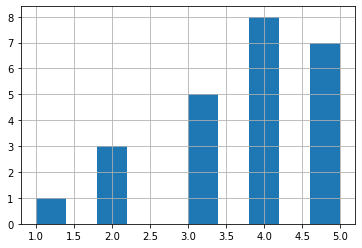

In [4]:
df_rating.ratings.hist()

The user ratings are mainly distributed between 3 and 5 scores

### Sparsity Determination

In [5]:
num_Sur_movieUsers = df_rating.userid.unique().shape[0]
num_Sur_movies = df_movie.movieid.unique().shape[0]

#Calculate sparse rate
Movie__matrixSparsity = 1 - len(df_rating) / (num_Sur_movieUsers * num_Sur_movies)

print('rating:{}, num_movieUsers:{}, num_movies:{}'.format(len(df_rating), num_Sur_movieUsers, num_Sur_movies))
print('Movie__matrixSparsity:', Movie__matrixSparsity)

rating:24, num_movieUsers:5, num_movies:6
Movie__matrixSparsity: 0.19999999999999996


### Find the lowest error from all algorithms in surprise

In [6]:
from surprise import Dataset, Reader, SVD, accuracy,SVDpp,SlopeOne,NMF,NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

In [7]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_rating[['userid','movieid','ratings']], reader)

In [8]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.167653,0.001568,0.000334
BaselineOnly,1.224093,0.000381,0.000000
KNNBasic,1.288960,0.000269,0.000000
KNNBaseline,1.295835,0.000238,0.000333
SVDpp,1.368247,0.001984,0.000000
KNNWithMeans,1.403821,0.000664,0.000334
CoClustering,1.458357,0.003324,0.000000
NormalPredictor,1.459759,0.000331,0.000000
NMF,1.483288,0.001266,0.000333


From the above table, the SVD has the lowest RMSE, thus I will use the SVD method to train the data to fill predict the missing values.

### Use matrix factorization model to fill the missing rating data¶

In [10]:
#train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

In [11]:
# map movie to id:
Mapping_file = dict(zip(df_movie.movietiltle.tolist(), df_movie.movieid.tolist()))

In [12]:
def pred_user_rating(ui):
    if ui in df_rating.userid.unique():
        ui_list = df_rating[df_rating.userid == ui].movieid.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():           
            predicted = algorithm.predict(ui, j)
            predictedL.append((j, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movieid', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        #pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

In [13]:
def insert_missing(list_userid):
    for user_id in list_userid:
        global df_rating
        df_pred = pred_user_rating(user_id)
        df_pred.insert(loc=0, column='userid', value=user_id)
        df_rating = df_rating.append(df_pred,ignore_index=True)
    return df_rating

In [14]:
list_userid = df_rating.userid.unique()

In [15]:
type(list_userid)

numpy.ndarray

In [16]:
insert_missing(list_userid)

,userid,movieid,ratings
0,1,1,5.000000
1,1,2,5.000000
2,1,3,3.000000
3,1,4,5.000000
4,2,1,3.000000
5,2,2,4.000000
6,2,3,1.000000
7,2,4,5.000000
8,2,5,5.000000
9,2,6,4.000000


In [17]:
# merging both the datasets on 'movieid' column
df_survey_movie_rating = pd.merge(df_movie, df_rating, on="movieid").sort_values(by = 'userid')
df_survey_movie_rating

,movieid,movietiltle,tag,userid,ratings
0,1,Forrest Gump,Romance,1,5.000000
23,5,Parasite,"Comedy, Thriller",1,3.537424
15,4,Spirited Away,"Crime, Animation",1,5.000000
10,3,Avengers: Endgame,"Action, Adventure",1,3.000000
5,2,Joker,"Crime, Thriller",1,5.000000
29,6,Soul,"Animation, Adventure, Comedy",1,3.348064
6,2,Joker,"Crime, Thriller",2,4.000000
25,6,Soul,"Animation, Adventure, Comedy",2,4.000000
1,1,Forrest Gump,Romance,2,3.000000
11,3,Avengers: Endgame,"Action, Adventure",2,1.000000


In [18]:
df_Sur_MovieRating_pivot = df_survey_movie_rating.pivot(index ='movieid', columns ='userid', values = 'ratings').fillna(0)

In [19]:
print(df_Sur_MovieRating_pivot.shape)
df_Sur_MovieRating_pivot.head(6)

(6, 5)


userid,1,2,3,4,5
movieid,,,,,
1,5.000000,3.0,4.000000,4.000000,5.000000
2,5.000000,4.0,3.289445,3.000000,3.160220
3,3.000000,1.0,4.000000,4.000000,2.000000
4,5.000000,5.0,2.000000,3.701649,5.000000
5,3.537424,5.0,4.000000,3.000000,3.449794
6,3.348064,4.0,2.000000,4.000000,3.000000


So far, we filled out all missing values.